In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os

# Our functions import

In [2]:
from generate_population_scripts import (generate_population,
                                         evaluate_distance_fitness, 
                                         evaluate_fitness_customers_count,
                                         evaluate_fitness_customers_served_demands,
                                         evaluate_fitness_vehicle_count,
                                         find_depot_using,
                                         get_evalution_count, 
                                         set_evaluation_count)
from combination import cut_and_crossfill, mutation_inverse, mutation_scramble
from selection import roulette_wheel, binary_tournament

In [14]:
def algorithm_run(pop_count, dataset, depot_location_dict, vehicle_count, selection_method, FITNESS_FUNCTION, MUTATION_METHOD, RECOMBINATION_METHOD, max_capacity=None, max_distance=None, p_m=0.1, p_c =0.9 ,max_evaluations = 5000, vehicle_depot_constraint=True, all_customers=True):
    """
    one constraint should be always given as input, the maximum capacity or maximum distance
    """
    ## reset the evaluation counts
    set_evaluation_count(0)

    population, fitness_pop = generate_population(max_capacity=max_capacity,
                                                     max_distance=max_distance,
                                                     depot_location_dict= depot_location_dict,
                                                     dataset=dataset, 
                                                     pop_count= pop_count,
                                                     vehicle_count= vehicle_count, 
                                                     fitness_function = FITNESS_FUNCTION, 
                                                     vehicle_depot_constraint = vehicle_depot_constraint,
                                                     all_customers=all_customers)
    generation_count = 0

    best_chromosome = None
    best_chromsome_fitness = None

    while get_evalution_count() < max_evaluations:
        print(f'Generation Count: {generation_count}, Evaluations number: {get_evalution_count()}')
        ## create pair of the parents
        parent_pairs = []
        for _ in range(pop_count):
            pair = selection_method(population, fitness_pop)
            parent_pairs.append(pair)

        
        offsprings = []
        fitness_offsprings = []
        for parents in parent_pairs:
            recombination_p = np.random.random()

            ## the offspring for this iteration
            iteration_offspring = []
            
            ######## Recombination ########
            if recombination_p < p_c:
                offspring1, offspring2 =  RECOMBINATION_METHOD(parents[0], parents[1], dataset, max_capacity, max_distance, depot_location_dict, vehicle_depot_constraint, vehicle_count)

                iteration_offspring = [offspring1, offspring2]

            
            ######## Mutation ########
            mutation_p = np.random.random()

            ## if cross over has happend
            if len(iteration_offspring) != 0 and mutation_p < p_m:
                offspring1 = MUTATION_METHOD(iteration_offspring[0], max_capacity, dataset, depot_location_dict, max_distance, vehicle_depot_constraint, vehicle_count)
                offspring2 = MUTATION_METHOD(iteration_offspring[1], max_capacity, dataset, depot_location_dict, max_distance, vehicle_depot_constraint, vehicle_count)

                iteration_offspring = [offspring1, offspring2]
            ## if cross over had not happened
            elif mutation_p < p_m:
                offspring1 = MUTATION_METHOD(parents[0], max_capacity, dataset, depot_location_dict, max_distance, vehicle_depot_constraint, vehicle_count)
                offspring2 = MUTATION_METHOD(parents[1], max_capacity, dataset, depot_location_dict, max_distance, vehicle_depot_constraint, vehicle_count)

                iteration_offspring = [offspring1, offspring2]
            ## if both cross over and mutation has not happened!
            else:
                iteration_offspring = [parents[0], parents[1]]
            
            ## to make sure everything works normal
            if iteration_offspring[0] == '':
                iteration_offspring[0] = parents[0]
            elif iteration_offspring[1] == '':
                iteration_offspring[1] = parents[1]
            else:
                iteration_offspring[0] = parents[0]
                iteration_offspring[1] = parents[1]
                
            ## finally append the genarated offsprings to offspring array 
            offsprings.append(iteration_offspring[0])
            offsprings.append(iteration_offspring[1])
            
            depot_symbol = find_depot_using(iteration_offspring[0], list(depot_location_dict.keys()))
            fitness_offsprings.append(FITNESS_FUNCTION(iteration_offspring[0], depot_location_dict[depot_symbol], dataset))
            depot_symbol = find_depot_using(iteration_offspring[1], list(depot_location_dict.keys()))
            fitness_offsprings.append(FITNESS_FUNCTION(iteration_offspring[1], depot_location_dict[depot_symbol], dataset))
            
                
        ## replace the old population with the new ones

        ## the whole generation: parents + offsprings
        generation_population = population.copy()
        generation_population.extend(offsprings)

        ## whole generation fitness: parents fitness + offsprings fitness
        generation_fitness = fitness_pop.copy()
        generation_fitness.extend(fitness_offsprings)

        ## the sorted generation
        generation_population_sorted = np.array(generation_population)[np.argsort(generation_fitness)]
        generation_fitness_sorted = np.sort(generation_fitness)

        ## Step 10
        ## extract the best of the new generation
        best_of_generation_population = generation_population_sorted[:pop_count]
        best_of_generation_fitness = generation_fitness_sorted[:pop_count]

        best_chromosome = generation_population_sorted[0]
        best_chromsome_fitness = generation_fitness_sorted[0]
        
        ## save them into the original population arrays
        population = best_of_generation_population.tolist()
        fitness_pop = best_of_generation_fitness.tolist()
        

        ## increase the generation value
        generation_count += 1
    
    return best_chromosome, best_chromsome_fitness

def plot_result(dataset, vehicle_solution, depot_locations_dict):
    """
    plot from the locations vehicles start and end their service
    the vehicle_solution is a chromsome as the shown in each part
    
    depot_locations_dict is the dictionary representing different depot locations available on the map
    """
    plt.figure(figsize=(15,10))
    for vehicle_number, vehicle in enumerate(vehicle_solution.split('|')):
        locations_x_served = []
        locations_y_served = []
        for idx in range(3, len(vehicle) + 1, 3):
            symbol = vehicle[idx-3: idx]
            ## if it was a repository
            if re.match('\(\d+\)', symbol):
                locations_x_served.append(depot_locations_dict[symbol][0])
                locations_y_served.append(depot_locations_dict[symbol][1])                
            else:
                customer_num = (int(symbol) - 100)
                customer = dataset[dataset.number == customer_num]
                loc_x, loc_y = customer.x.values[0], customer.y.values[0]
                locations_x_served.append(loc_x)
                locations_y_served.append(loc_y)
                plt.text(loc_x, loc_y, s=f'{customer_num}')
        plt.plot(locations_x_served, locations_y_served, label=f'vehicle number:{vehicle_number}', marker='^', linestyle='--', alpha=0.5, zorder=-1)
    
    ## ploting the depositories
    for depot_symbol in depot_locations_dict.keys():
        plt.scatter(depot_locations_dict[depot_symbol][0], depot_locations_dict[depot_symbol][1], marker='+', c='k', label=f'Depot: {depot_symbol}', zorder=1)

    plt.legend()
    plt.plot()

# PROBLEM No. 1
The goal is to minimize the distance gone, of the vehicles with the parameters below
- There is 1 depot in the location `(-14, 9)`
- There are `6` vehicles
- Maximum Capacity is `70`
- The locations of the customers and their demands are in `P1.txt` file
- The distance each vehicle can go is not limited.

In [64]:
p1_data = pd.read_csv('data/P1.txt', delimiter=' ')
DEPOT_LOCATION = (-14, 9)
with open(os.path.join('results', 'problem1_depot.txt'), 'w') as file:
    json.dump({'(1)': DEPOT_LOCATION}, file)

In [5]:
problem1_best_chromsome, problem1_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p1_data,
                depot_location_dict= {'(1)': DEPOT_LOCATION},
                max_capacity=70, 
                vehicle_count=6, 
                max_distance=None,
                selection_method=binary_tournament,
                FITNESS_FUNCTION=evaluate_distance_fitness,
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000)

problem1_best_chromsome, problem1_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450
Generation Count: 5, Evaluations number: 550
Generation Count: 6, Evaluations number: 650
Generation Count: 7, Evaluations number: 750
Generation Count: 8, Evaluations number: 850
Generation Count: 9, Evaluations number: 950
Generation Count: 10, Evaluations number: 1050
Generation Count: 11, Evaluations number: 1150
Generation Count: 12, Evaluations number: 1250
Generation Count: 13, Evaluations number: 1350
Generation Count: 14, Evaluations number: 1450
Generation Count: 15, Evaluations number: 1550
Generation Count: 16, Evaluations number: 1650
Generation Count: 17, Evaluations number: 1750
Generation Count: 18, Evaluations number: 1850
Generation Count: 19, Evaluations number: 1950
Generation Count: 20, Evaluations number: 2050
Generation Count: 21, Evaluations 

('(1)108161136(1)|(1)179117182135(1)195198166175143(1)|(1)153110180144199(1)102109192145159183128131(1)|(1)137134106133171187104146(1)157101130151116186(1)191163141124(1)142139185164126(1)|(1)103113150200148(1)122176129147(1)193155188(1)149168167114(1)132174170125172123(1)111154194158(1)115165181112140162(1)|(1)118190178107184196160(1)127119121156152(1)|(1)120197189173(1)169138105177(1)',
 6380)

In [26]:
## save results
with open(os.path.join('results', 'problem1_chromosome.txt'), 'w') as file:
    file.write(problem1_best_chromsome)

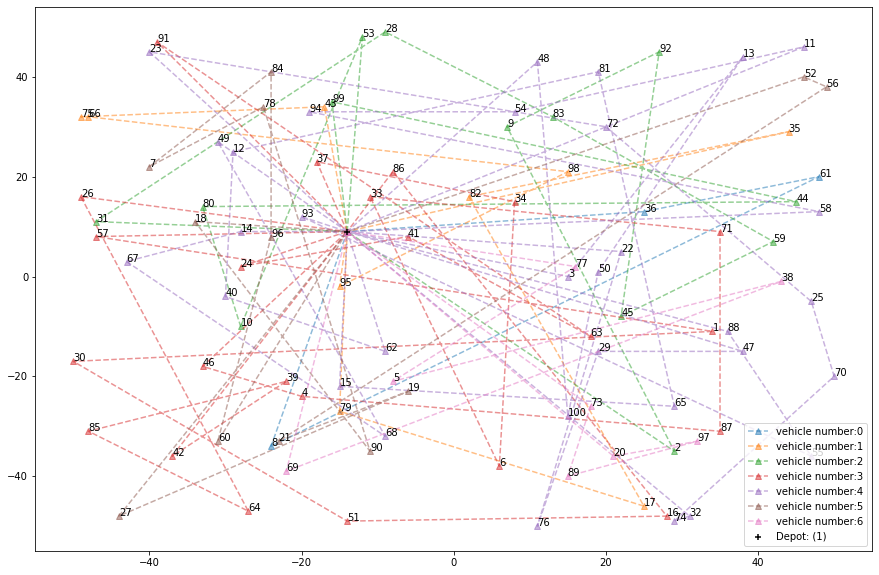

In [8]:
plot_result(p1_data ,problem1_best_chromsome, {'(1)': DEPOT_LOCATION})

# Problem No. 2
The goal is to maximize the customers recieved service with parametes below
- There is 1 depot in the location `(0, 13)`
- There are `4` vehicles
- Maximum distace each vehicle can go is `200` Km
- The locations of the customers and their demands are in `P2.txt` file
- The capacity is not limited for vehicles

In [56]:
p2_data = pd.read_csv('data/P2.txt', delimiter=' ')
DEPOT_LOCATION = (0, 13)
with open(os.path.join('results', 'problem2_depot.txt'), 'w') as file:
    json.dump({'(1)': DEPOT_LOCATION}, file)

In [10]:
problem2_best_chromsome, problem2_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p2_data,
                depot_location_dict= {'(1)': DEPOT_LOCATION},
                max_capacity=None, 
                max_distance=200,
                vehicle_count=4, 
                selection_method=binary_tournament,
                FITNESS_FUNCTION=evaluate_fitness_customers_count,
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000, 
                all_customers=False)

problem2_best_chromsome, problem2_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450
Generation Count: 5, Evaluations number: 550
Generation Count: 6, Evaluations number: 650
Generation Count: 7, Evaluations number: 750
Generation Count: 8, Evaluations number: 850
Generation Count: 9, Evaluations number: 950
Generation Count: 10, Evaluations number: 1050
Generation Count: 11, Evaluations number: 1150
Generation Count: 12, Evaluations number: 1250
Generation Count: 13, Evaluations number: 1350
Generation Count: 14, Evaluations number: 1450
Generation Count: 15, Evaluations number: 1550
Generation Count: 16, Evaluations number: 1650
Generation Count: 17, Evaluations number: 1750
Generation Count: 18, Evaluations number: 1850
Generation Count: 19, Evaluations number: 1950
Generation Count: 20, Evaluations number: 2050
Generation Count: 21, Evaluations 

('(1)104136131178200181189123198129165172126121139171149168132116107197193156163191130146117192105162147112127160187188176196199141153134(1)|(1)144157194185182174143113103186138(1)|(1)109108169175(1)|(1)180190183142(1)',
 0.015873015873015872)

In [25]:
## save results
with open(os.path.join('results', 'problem2_chromosome.txt'), 'w') as file:
    file.write(problem2_best_chromsome)

In [11]:
problem2_best_chromsome.count('|')

3

In [12]:
## the number of customers served
1 / problem2_best_chromsome_fitness

63.0

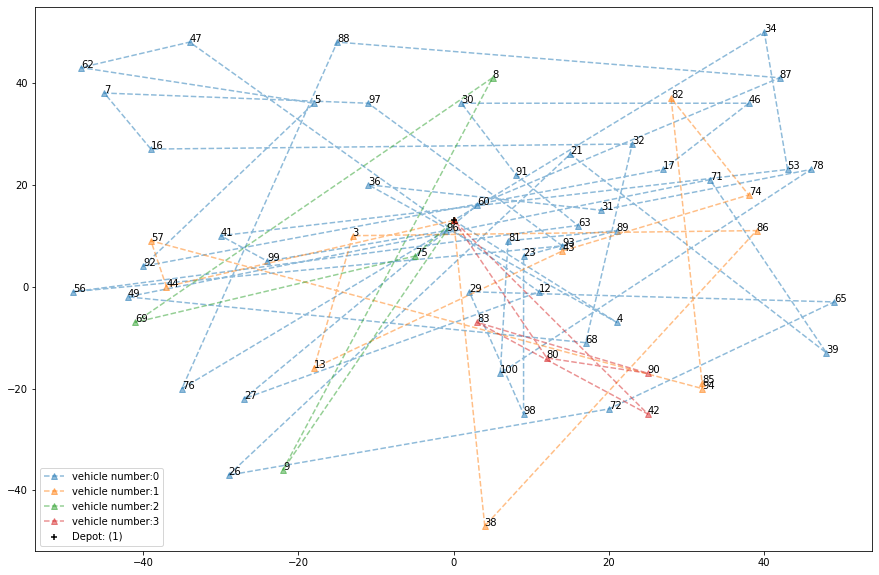

In [13]:
plot_result(p2_data, problem2_best_chromsome, {'(1)': DEPOT_LOCATION})

# Problem No. 3
The goal is to maximize the demands of customers with parametes below
- There is 1 depot in the location `(-17, -4)`
- There are `4` vehicles
- Maximum distace each vehicle can go is `200` Km
- The locations of the customers and their demands are in `P3.txt` file
- The capacity is not limited for vehicles

In [66]:
p3_data = pd.read_csv('data/P3.txt', delimiter=' ')
DEPOT_LOCATION = (-17, -4)

with open(os.path.join('results', 'problem3_depot.txt'), 'w') as file:
    json.dump({'(1)': DEPOT_LOCATION}, file)

In [15]:
problem3_best_chromsome, problem3_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p3_data,
                depot_location_dict= {'(1)': DEPOT_LOCATION},
                max_capacity=None, 
                max_distance=200,
                vehicle_count=4, 
                selection_method=binary_tournament,
                FITNESS_FUNCTION=evaluate_fitness_customers_served_demands,
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000, 
                all_customers=False)

problem3_best_chromsome, problem3_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450
Generation Count: 5, Evaluations number: 550
Generation Count: 6, Evaluations number: 650
Generation Count: 7, Evaluations number: 750
Generation Count: 8, Evaluations number: 850
Generation Count: 9, Evaluations number: 950
Generation Count: 10, Evaluations number: 1050
Generation Count: 11, Evaluations number: 1150
Generation Count: 12, Evaluations number: 1250
Generation Count: 13, Evaluations number: 1350
Generation Count: 14, Evaluations number: 1450
Generation Count: 15, Evaluations number: 1550
Generation Count: 16, Evaluations number: 1650
Generation Count: 17, Evaluations number: 1750
Generation Count: 18, Evaluations number: 1850
Generation Count: 19, Evaluations number: 1950
Generation Count: 20, Evaluations number: 2050
Generation Count: 21, Evaluations 

('(1)195159174120136102181198156176180166200158129111197179132191192183(1)|(1)196160121177150153162128155194101124107115146182184126190103193(1)|(1)157152171168167134151178172109187144(1)|(1)130123189149148105113154(1)',
 0.00013559322033898305)

In [24]:
## save results
with open(os.path.join('results', 'problem3_chromosome.txt'), 'w') as file:
    file.write(problem3_best_chromsome)

In [16]:
## the maximum value of served demands 
1 / problem3_best_chromsome_fitness

7375.0

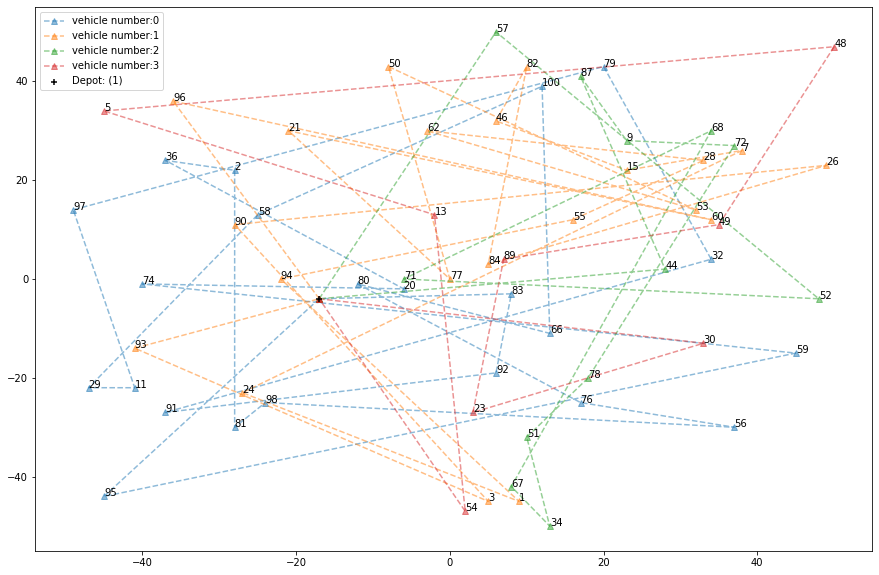

In [17]:
plot_result(p3_data,problem3_best_chromsome, {'(1)': DEPOT_LOCATION})

# Problem No. 4
The goal is to minimize number of vehicles with parametes below
- There is 1 depot in the location `(24, -7)`
- There are `?` vehicles (optimization objective)
- Maximum distace each vehicle can go is `200` Km
- The locations of the customers and their demands are in `P4.txt` file
- The capacity is not limited for vehicles

In [67]:
p4_data = pd.read_csv('data/P4.txt', delimiter=' ')
DEPOT_LOCATION = (24, -7)

with open(os.path.join('results', 'problem4_depot.txt'), 'w') as file:
    json.dump({'(1)': DEPOT_LOCATION}, file)

In [19]:
problem4_best_chromsome, problem4_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p4_data,
                depot_location_dict= {'(1)': DEPOT_LOCATION},
                max_capacity=None, 
                max_distance=200,
                vehicle_count=None, 
                selection_method=binary_tournament,
                FITNESS_FUNCTION=evaluate_fitness_vehicle_count,
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000,
                all_customers=False)

problem4_best_chromsome, problem4_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450
Generation Count: 5, Evaluations number: 550
Generation Count: 6, Evaluations number: 650
Generation Count: 7, Evaluations number: 750
Generation Count: 8, Evaluations number: 850
Generation Count: 9, Evaluations number: 950
Generation Count: 10, Evaluations number: 1050
Generation Count: 11, Evaluations number: 1150
Generation Count: 12, Evaluations number: 1250
Generation Count: 13, Evaluations number: 1350
Generation Count: 14, Evaluations number: 1450
Generation Count: 15, Evaluations number: 1550
Generation Count: 16, Evaluations number: 1650
Generation Count: 17, Evaluations number: 1750
Generation Count: 18, Evaluations number: 1850
Generation Count: 19, Evaluations number: 1950
Generation Count: 20, Evaluations number: 2050
Generation Count: 21, Evaluations 

('(1)230144176119186245103235201139190189241188224138207120169116112208132167106237233140198125179111130135192211229137113102128249104143193243194156109(1)|(1)168191134121181153123160184196170118129226250127197215147228141145172236151114238124117162166163225158177173209218216148195219234101175155203(1)|(1)146248187133199110159174180213212206165154185205240242164246200122217204231202126178150221108(1)|(1)239214136182115220149131222210183232171105157247142(1)|(1)152244161107(1)|(1)227223(1)|(1)',
 11.744285714285715)

In [23]:
## save results
with open(os.path.join('results', 'problem4_chromosome.txt'), 'w') as file:
    file.write(problem4_best_chromsome)

In [20]:
## the vehicle count used
problem4_best_chromsome.count('|')

6

In [21]:
## the mean distance over the limit
(problem4_best_chromsome_fitness - int(problem4_best_chromsome_fitness)) * 200

148.85714285714295

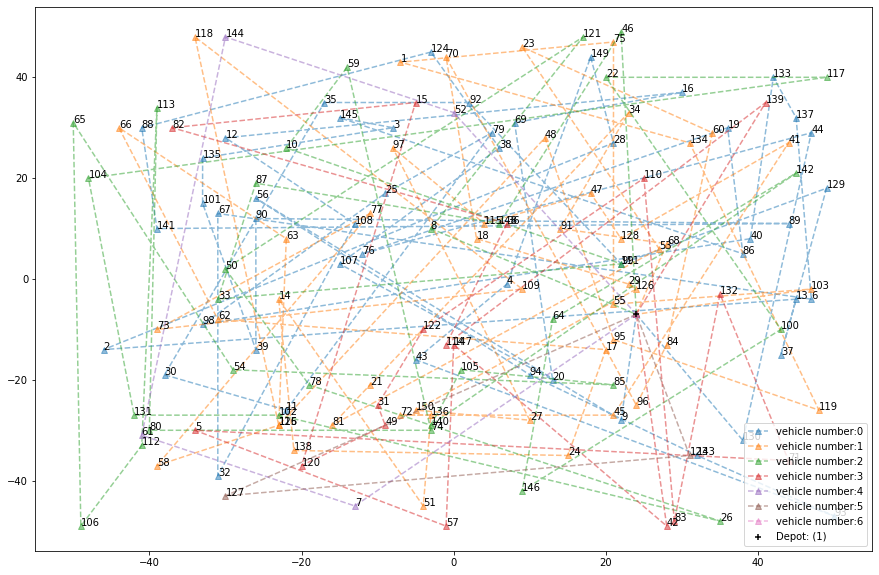

In [22]:
plot_result(p4_data, problem4_best_chromsome, {'(1)': DEPOT_LOCATION})

# Problem No. 5
The goal is to minimize the distance gone, of the vehicles with the parameters below
- There are 3 depot in the location `(31, 6)`, `(-31, 7)`, `(25, -10)`.
- There are `11` vehicles
- Maximum Capacity is `100`
- The locations of the customers and their demands are in `P5.txt` file
- The distance each vehicle can go is not limited.

In [61]:
p5_data = pd.read_csv('data/P5.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (31, 6),
    '(2)': (-31, 7),
    '(3)': (25, -10)
}    
with open(os.path.join('results', 'problem5_depot.txt'), 'w') as file:
    json.dump(DEPOT_LOCATIONS_dict, file)

In [24]:
problem5_best_chromsome, problem5_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p5_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=100, 
                max_distance=None,
                vehicle_count=11, 
                selection_method=binary_tournament,
                FITNESS_FUNCTION=evaluate_distance_fitness,
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000)

problem5_best_chromsome, problem5_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450
Generation Count: 5, Evaluations number: 550
Generation Count: 6, Evaluations number: 650
Generation Count: 7, Evaluations number: 750
Generation Count: 8, Evaluations number: 850
Generation Count: 9, Evaluations number: 950
Generation Count: 10, Evaluations number: 1050
Generation Count: 11, Evaluations number: 1150
Generation Count: 12, Evaluations number: 1250
Generation Count: 13, Evaluations number: 1350
Generation Count: 14, Evaluations number: 1450
Generation Count: 15, Evaluations number: 1550
Generation Count: 16, Evaluations number: 1650
Generation Count: 17, Evaluations number: 1750
Generation Count: 18, Evaluations number: 1850
Generation Count: 19, Evaluations number: 1950
Generation Count: 20, Evaluations number: 2050
Generation Count: 21, Evaluations 

('(1)209139126141168157205225(1)|(1)182142204151245166242195(1)127238143224164181189(1)|(1)171212214(1)123160234158(1)|(1)110116178109191193(1)154196170135153(1)|(1)118145247223112222125172(1)232200176199102(1)132244241133230121184(1)114150147101198148235117218208197(1)|(1)163236131104128179215180(1)220233146(1)111159(1)|(1)174122156169243201219(1)185190130240192187202120(1)|(1)175103239(1)105183177119108216144(1)246129211213221173124(1)248249155107137188217152(1)|(1)140149207(1)|(1)165186115162136(1)|(1)229250210206161(1)|(1)134106228226227167113(1)203138231237194(1)',
 9640)

In [68]:
## save results
with open(os.path.join('results', 'problem5_chromosome.txt'), 'w') as file:
    file.write(problem5_best_chromsome)

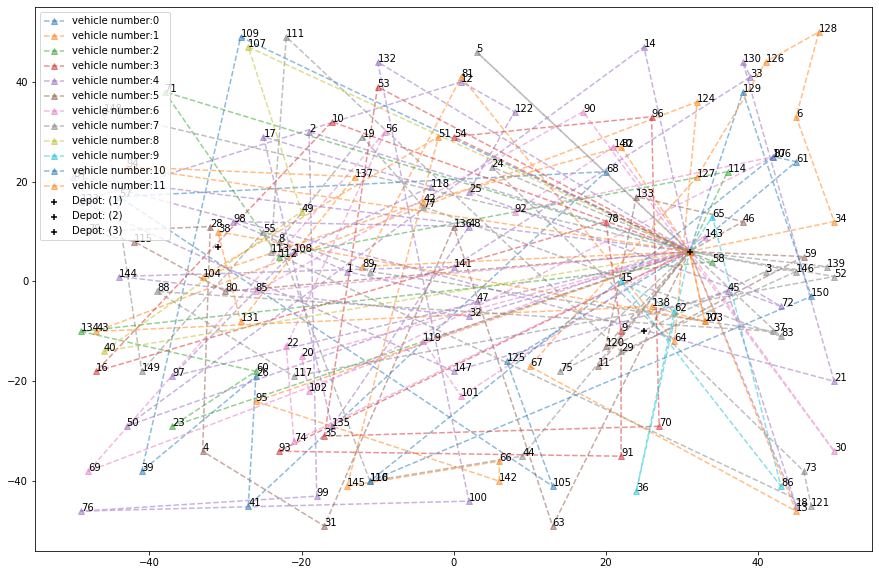

In [25]:
plot_result(p5_data, problem5_best_chromsome, DEPOT_LOCATIONS_dict)

# Problem No. 6
The goal is to maximize the customers recieved service with parametes below
- There are two depots in the location `(11, 36)`, `(19, -41)`
- There are `7` vehicles
- Maximum distace each vehicle can go is `250` Km
- The locations of the customers and their demands are in `P6.txt` file
- The capacity is not limited for vehicles

In [69]:
p6_data = pd.read_csv('data/P6.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (11, 36),
    '(2)': (19, -41)
}    
with open(os.path.join('results', 'problem6_depot.txt'), 'w') as file:
    json.dump(DEPOT_LOCATIONS_dict, file)

In [27]:
problem6_best_chromsome, problem6_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p6_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=None, 
                max_distance=250,
                vehicle_count=7, 
                selection_method=binary_tournament,
                FITNESS_FUNCTION=evaluate_fitness_customers_count,
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000, 
                all_customers=False)

problem6_best_chromsome, problem6_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450
Generation Count: 5, Evaluations number: 550
Generation Count: 6, Evaluations number: 650
Generation Count: 7, Evaluations number: 750
Generation Count: 8, Evaluations number: 850
Generation Count: 9, Evaluations number: 950
Generation Count: 10, Evaluations number: 1050
Generation Count: 11, Evaluations number: 1150
Generation Count: 12, Evaluations number: 1250
Generation Count: 13, Evaluations number: 1350
Generation Count: 14, Evaluations number: 1450
Generation Count: 15, Evaluations number: 1550
Generation Count: 16, Evaluations number: 1650
Generation Count: 17, Evaluations number: 1750
Generation Count: 18, Evaluations number: 1850
Generation Count: 19, Evaluations number: 1950
Generation Count: 20, Evaluations number: 2050
Generation Count: 21, Evaluations 

('(2)167131148143106115173159139145193144217151179130170192152101126200195186177146162208219136198203114119150116(2)|(2)138121117108212202209118109191172142163182181132135213112128102215(2)|(2)210110113166140157124218153111183216188107137125122(2)|(2)129176204184104185141197187174169158178(2)|(2)120214127165134168154206220199171103(2)|(2)155190149123180175164156211(2)|(2)133(2)',
 0.00909090909090909)

In [27]:
## save results
with open(os.path.join('results', 'problem6_chromosome.txt'), 'w') as file:
    file.write(problem6_best_chromsome)

In [28]:
1 / problem6_best_chromsome_fitness

110.0

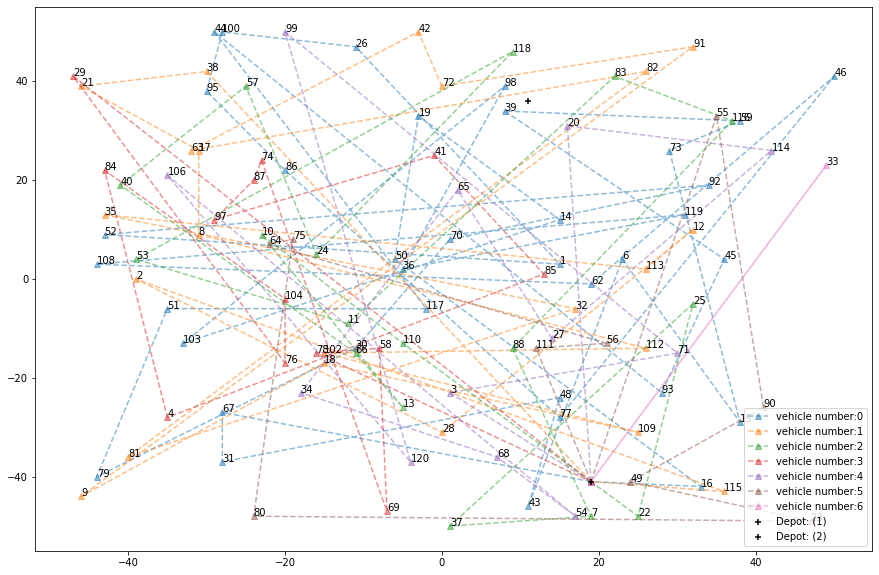

In [29]:
plot_result(p6_data, problem6_best_chromsome, DEPOT_LOCATIONS_dict)

# Problem No. 7
The goal is to maximize the demands of customers with parametes below
- There are three depots in the locations `(44, -41)`, `(-24, -8)`, `(-33, 30)`, `(10, 43)`
- There are `10` vehicles
- Maximum distace each vehicle can go is `250` Km
- The locations of the customers and their demands are in `P7.txt` file
- The capacity is not limited for vehicles

In [70]:
p7_data = pd.read_csv('data/P7.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (44, -41),
    '(2)': (-24, -8),
    '(3)': (-33, 30),
    '(4)': (10, 43)
}
with open(os.path.join('results', 'problem7_depot.txt'), 'w') as file:
    json.dump(DEPOT_LOCATIONS_dict, file)

In [31]:
problem7_best_chromsome, problem7_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p7_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=None, 
                max_distance=250,
                vehicle_count=10, 
                selection_method=binary_tournament,
                FITNESS_FUNCTION=evaluate_fitness_customers_served_demands,
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000,
                all_customers=False)

problem7_best_chromsome, problem7_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450
Generation Count: 5, Evaluations number: 550
Generation Count: 6, Evaluations number: 650
Generation Count: 7, Evaluations number: 750
Generation Count: 8, Evaluations number: 850
Generation Count: 9, Evaluations number: 950
Generation Count: 10, Evaluations number: 1050
Generation Count: 11, Evaluations number: 1150
Generation Count: 12, Evaluations number: 1250
Generation Count: 13, Evaluations number: 1350
Generation Count: 14, Evaluations number: 1450
Generation Count: 15, Evaluations number: 1550
Generation Count: 16, Evaluations number: 1650
Generation Count: 17, Evaluations number: 1750
Generation Count: 18, Evaluations number: 1850
Generation Count: 19, Evaluations number: 1950
Generation Count: 20, Evaluations number: 2050
Generation Count: 21, Evaluations 

('(4)220186267129152187171265264159246194111285123192164144274254231257228151260155209175255191126134282161280200295136270147288297121251259291143130140289105290204120241106190218139(4)|(4)137117183287262242299235248293124108178102181250202179225224165216112229114272118150201294261269198163197298226113244148169278252223284275296266156258(4)|(4)286292154104276184160213237158210149271206222238116273172236135247166263234239230215189142174256196103133185170(4)|(4)138109279176153115125281(4)|(4)127177167168101268214(4)|(4)249283122221107199(4)|(4)212253217208240(4)|(4)193110203157(4)|(4)300145245219(4)|(4)162(4)',
 5.471956224350205e-05)

In [28]:
## save results
with open(os.path.join('results', 'problem7_chromosome.txt'), 'w') as file:
    file.write(problem7_best_chromsome)

In [32]:
1 / problem7_best_chromsome_fitness

18275.0

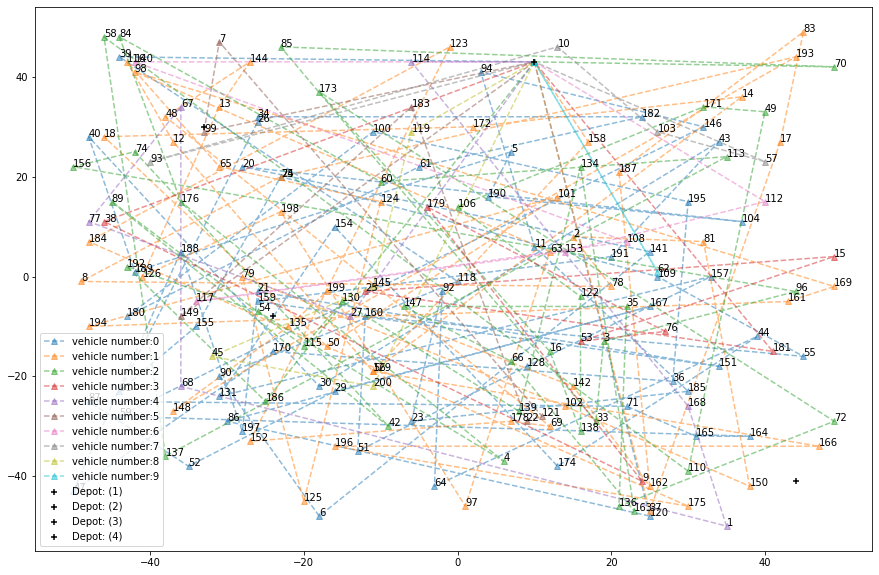

In [33]:
plot_result(p7_data, problem7_best_chromsome, DEPOT_LOCATIONS_dict)

# Problem No. 8
Is same as problem 4, but having multiple depot

In [71]:
p8_data = pd.read_csv('data/P8.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (8, 17),
    '(2)': (31, -42),
    '(3)': (-6, -22),
    '(4)': (15, -10),
    '(5)': (-27, 43)
}
with open(os.path.join('results', 'problem8_depot.txt'), 'w') as file:
    json.dump(DEPOT_LOCATIONS_dict, file)

In [35]:
problem8_best_chromsome, problem8_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p8_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=None, 
                max_distance=200,
                vehicle_count=None, 
                selection_method=binary_tournament,
                FITNESS_FUNCTION=evaluate_fitness_vehicle_count,
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000)

problem8_best_chromsome, problem8_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450
Generation Count: 5, Evaluations number: 550
Generation Count: 6, Evaluations number: 650
Generation Count: 7, Evaluations number: 750
Generation Count: 8, Evaluations number: 850
Generation Count: 9, Evaluations number: 950
Generation Count: 10, Evaluations number: 1050
Generation Count: 11, Evaluations number: 1150
Generation Count: 12, Evaluations number: 1250
Generation Count: 13, Evaluations number: 1350
Generation Count: 14, Evaluations number: 1450
Generation Count: 15, Evaluations number: 1550
Generation Count: 16, Evaluations number: 1650
Generation Count: 17, Evaluations number: 1750
Generation Count: 18, Evaluations number: 1850
Generation Count: 19, Evaluations number: 1950
Generation Count: 20, Evaluations number: 2050
Generation Count: 21, Evaluations 

('(2)137155135113178121183169120118157196116146111114193103186147141204127123184144109211159150130145176213151167162209139110131143165108200122153161191219107166104101197164112105148198179190194195163217142181117134(2)|(2)189133158218129126160115156212206187124128202119102125170140175149188172192132177173136199216(2)|(2)138182214185154220106203210(2)|(2)205171174201208180215152(2)|(2)207168(2)|(2)',
 10.725)

In [29]:
## save results
with open(os.path.join('results', 'problem8_chromosome.txt'), 'w') as file:
    file.write(problem8_best_chromsome)

In [36]:
## the vehicle count used
problem8_best_chromsome.count('|')

5

In [37]:
## the mean distance over the limit
(problem8_best_chromsome_fitness - int(problem8_best_chromsome_fitness)) * 200

144.99999999999994

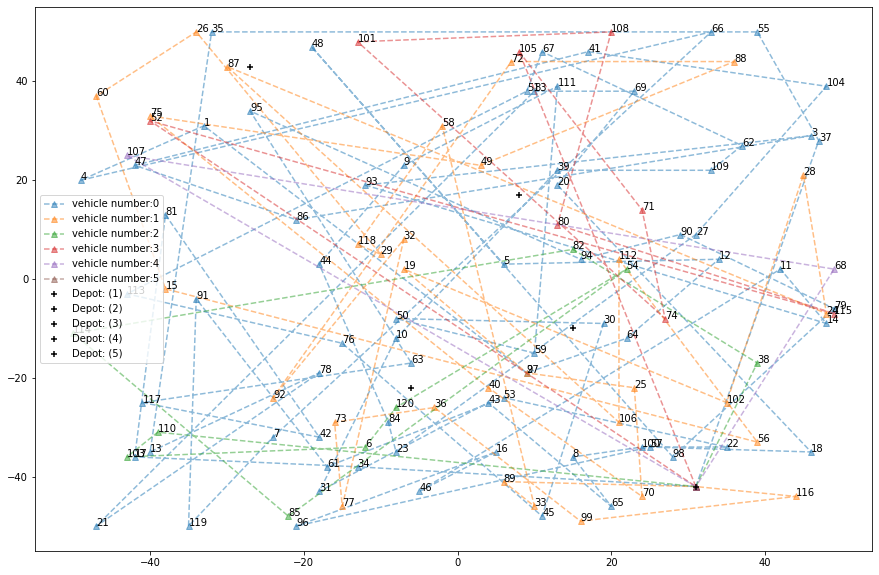

In [38]:
plot_result(p8_data, problem8_best_chromsome, DEPOT_LOCATIONS_dict)

# Problem No. 9
The goal is to minimum the distance gone as the Problems 2 and 5 but the difference is that the vehicle can go and back to another depot, and start from that depot! 

In [72]:
p9_data = pd.read_csv('data/P9.txt', delimiter=' ')
DEPOT_LOCATIONS_dict = {
    '(1)': (8, 17),
    '(2)': (31, -42),
    '(3)': (-6, -22),
    '(4)': (15, -10),
    '(5)': (-27, 43)
}    
with open(os.path.join('results', 'problem9_depot.txt'), 'w') as file:
    json.dump(DEPOT_LOCATIONS_dict, file)

In [15]:
problem9_best_chromsome, problem9_best_chromsome_fitness = algorithm_run(pop_count = 50, 
                dataset=p9_data,
                depot_location_dict= DEPOT_LOCATIONS_dict,
                max_capacity=100, 
                max_distance=None,
                vehicle_count=11, 
                selection_method=binary_tournament,
                FITNESS_FUNCTION=evaluate_distance_fitness,
                MUTATION_METHOD=mutation_scramble,
                RECOMBINATION_METHOD=cut_and_crossfill,
                max_evaluations=5000, 
                vehicle_depot_constraint=False)

problem9_best_chromsome, problem9_best_chromsome_fitness

Generation Count: 0, Evaluations number: 50
Generation Count: 1, Evaluations number: 150
Generation Count: 2, Evaluations number: 250
Generation Count: 3, Evaluations number: 350
Generation Count: 4, Evaluations number: 450
Generation Count: 5, Evaluations number: 550
Generation Count: 6, Evaluations number: 650
Generation Count: 7, Evaluations number: 750
Generation Count: 8, Evaluations number: 850
Generation Count: 9, Evaluations number: 950
Generation Count: 10, Evaluations number: 1050
Generation Count: 11, Evaluations number: 1150
Generation Count: 12, Evaluations number: 1250
Generation Count: 13, Evaluations number: 1350
Generation Count: 14, Evaluations number: 1450
Generation Count: 15, Evaluations number: 1550
Generation Count: 16, Evaluations number: 1650
Generation Count: 17, Evaluations number: 1750
Generation Count: 18, Evaluations number: 1850
Generation Count: 19, Evaluations number: 1950
Generation Count: 20, Evaluations number: 2050
Generation Count: 21, Evaluations 

('(3)146108112179(3)|(3)180159135161152122151149158147129(3)|(3)124162165172104106163145111139(4)|(4)125155168131141140(3)|(3)144175148128130137114101110132138174(3)|(3)177118154166136(1)|(1)123171178102142120(4)|(4)105134150127109164173107121133(3)|(3)113126167160(1)|(1)169170116(4)|',
 4922)

In [30]:
## save results
with open(os.path.join('results', 'problem9_chromosome.txt'), 'w') as file:
    file.write(problem9_best_chromsome)

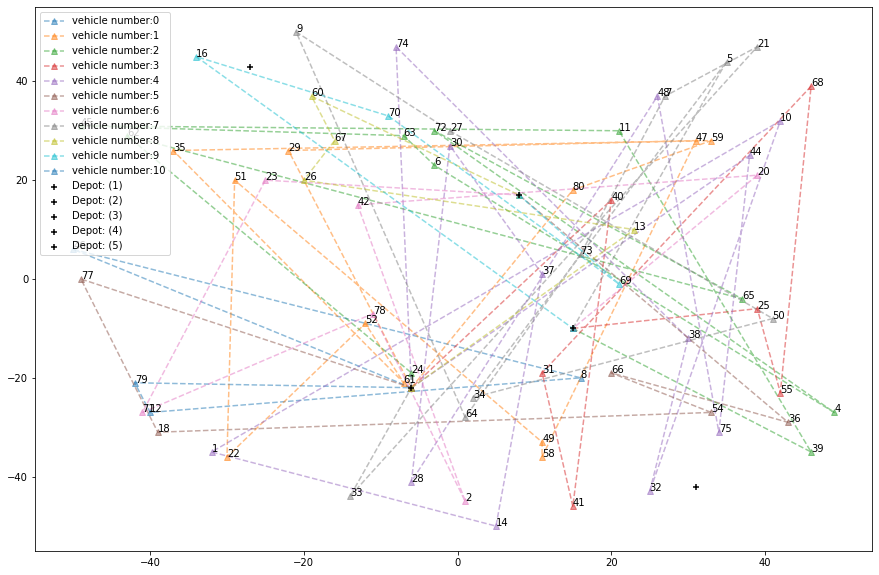

In [16]:
plot_result(p9_data, problem9_best_chromsome, DEPOT_LOCATIONS_dict)

# Problem No. 10